In [14]:
import tensorflow as tf
tf.get_logger().setLevel(40) # suppress deprecation messages
tf.compat.v1.disable_v2_behavior() # disable TF2 behaviour as alibi code still relies on TF1 constructs
import tensorflow.keras as keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D, Input, UpSampling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
from alibi.explainers import CEM

from tensorflow_model import load_image
import numpy as np
import random

print('TF version: ', tf.__version__)
print('Eager execution enabled: ', tf.executing_eagerly()) # False

TF version:  2.8.0
Eager execution enabled:  False


# Use ImageNetV2 "MatchedFrequency" test set

In [8]:
# TODO: datset_creater anschauen; true lables are still missing

In [9]:
from torchvision import datasets
data_handler = datasets.ImageFolder(root="C:/Users/julia/OneDrive/Dokumente/GitHub/development/files/imagenetv2-matched-frequency-format-val")

In [10]:
def sample_random_images(data_handler, number, seed=None):
    images = []
    img_paths = data_handler.imgs.copy()
    if seed:
        random.seed(seed)
    for i in range(number):
        rand_idx = random.randint(0, len(img_paths))
        rand_img_path = img_paths.pop(rand_idx)[0]
        rand_img = data_handler.loader(rand_img_path)
        # resize
        rand_img = rand_img.resize((224, 224))
        # convert to np array
        images.append(np.array(rand_img))
    return np.array(images)

In [11]:
x_test = sample_random_images(data_handler, 5, 5)

In [12]:
for img in images:
    plt.imshow(img)

NameError: name 'images' is not defined

# Load pretrained CNN model

In [189]:
cnn = tf.keras.applications.VGG16(
    include_top=True,
    weights='imagenet',
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000
)

# Train or load auto-encoder

In [1]:
from autoencoder.autoencoder import Autoencoder

In [30]:
#ae = Autoencoder(load_path="files/iamgenet_ae3.h5")
ae = Autoencoder()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [26]:
ae_train_images = np.load("autoencoder/train_imagenet.npy")

In [ ]:
ae.fit(data_path="./autoencoder/train_imagenet.npy", epochs=50, use_multiprocessing=True)

Train on 400 samples, validate on 100 samples
Epoch 1/50
400/400 [==============================] - 327s 817ms/sample - loss: 0.1025 - val_loss: 0.1041
Epoch 2/50
400/400 [==============================] - 326s 815ms/sample - loss: 0.1006 - val_loss: 0.1041
Epoch 3/50
400/400 [==============================] - 346s 865ms/sample - loss: 0.0979 - val_loss: 0.1015
Epoch 4/50
400/400 [==============================] - 4473s 11s/sample - loss: 0.0966 - val_loss: 0.1027
Epoch 5/50
400/400 [==============================] - 293s 733ms/sample - loss: 0.0950 - val_loss: 0.0982
Epoch 6/50
400/400 [==============================] - 388s 971ms/sample - loss: 0.0920 - val_loss: 0.0960
Epoch 7/50
400/400 [==============================] - 253s 633ms/sample - loss: 0.0889 - val_loss: 0.1013
Epoch 8/50
400/400 [==============================] - 254s 634ms/sample - loss: 0.0886 - val_loss: 0.0982
Epoch 9/50
400/400 [==============================] - 258s 645ms/sample - loss: 0.0868 - val_loss: 0.0930
E

In [5]:
ae.save("files/iamgenet_ae3.h5")

In [27]:
# Compare original with decoded images
decoded_imgs = ae.predict(ae_train_images[:5] / 255)

In [28]:
decoded_imgs[0]

array([[[0.06608753, 0.        , 0.13042353],
        [0.15160899, 0.        , 0.15847863],
        [0.19295369, 0.        , 0.17408231],
        ...,
        [0.20592092, 0.        , 0.14014438],
        [0.18330611, 0.        , 0.11971605],
        [0.1314872 , 0.        , 0.02845641]],

       [[0.07867925, 0.        , 0.16484267],
        [0.1969025 , 0.        , 0.21226427],
        [0.25644735, 0.        , 0.22280623],
        ...,
        [0.2853653 , 0.        , 0.18836996],
        [0.26125807, 0.        , 0.17272173],
        [0.17904468, 0.        , 0.05746138]],

       [[0.10883846, 0.        , 0.19097759],
        [0.25912502, 0.        , 0.24319178],
        [0.3351326 , 0.        , 0.25175932],
        ...,
        [0.37097713, 0.        , 0.20160243],
        [0.33458576, 0.        , 0.18468706],
        [0.22052373, 0.        , 0.05676901]],

       ...,

       [[0.09831027, 0.        , 0.16269755],
        [0.23175278, 0.        , 0.21831144],
        [0.29642594, 0

In [24]:
x_test[0] / 255

array([[[0.81960784, 0.72941176, 0.59607843],
        [0.81960784, 0.72941176, 0.59607843],
        [0.81960784, 0.72941176, 0.59607843],
        ...,
        [0.14509804, 0.14117647, 0.1254902 ],
        [0.14509804, 0.14117647, 0.1254902 ],
        [0.14901961, 0.13333333, 0.1372549 ]],

       [[0.81568627, 0.7254902 , 0.59215686],
        [0.81568627, 0.7254902 , 0.59215686],
        [0.81568627, 0.7254902 , 0.59215686],
        ...,
        [0.14509804, 0.14117647, 0.1254902 ],
        [0.14509804, 0.14117647, 0.1254902 ],
        [0.14901961, 0.13333333, 0.13333333]],

       [[0.81176471, 0.7254902 , 0.58039216],
        [0.81176471, 0.7254902 , 0.58039216],
        [0.81176471, 0.7254902 , 0.58039216],
        ...,
        [0.14509804, 0.14117647, 0.1254902 ],
        [0.14509804, 0.14117647, 0.1254902 ],
        [0.14901961, 0.13333333, 0.12941176]],

       ...,

       [[0.18823529, 0.20784314, 0.16862745],
        [0.19215686, 0.20392157, 0.16862745],
        [0.19607843, 0

In [ ]:
# Compare original with decoded images
n = 5
plt.figure(figsize=(20, 4))
for i in range(1, n+1):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i-1])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i-1])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Generate contrastive explanation with pertinent negative

In [236]:
idx = 3
X = x_test[idx].reshape((1,) + x_test[idx].shape)
X = X / 255

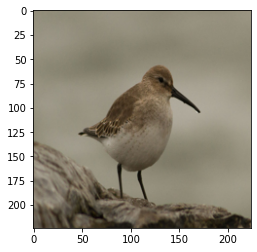

In [237]:
plt.imshow(X[0]);

In [239]:
cnn.predict(X).argmax(), cnn.predict(X).max()

(669, 0.05173149)

In [220]:
# CEM parameters
mode = 'PN'  # 'PN' (pertinent negative) or 'PP' (pertinent positive)
shape = (1,) + x_test.shape[1:]  # instance shape
kappa = 0.  # minimum difference needed between the prediction probability for the perturbed instance on the
            # class predicted by the original instance and the max probability on the other classes
            # in order for the first loss term to be minimized
beta = .1  # weight of the L1 loss term
gamma = 100  # weight of the optional auto-encoder loss term
c_init = 1.  # initial weight c of the loss term encouraging to predict a different class (PN) or
              # the same class (PP) for the perturbed instance compared to the original instance to be explained
c_steps = 10  # nb of updates for c
max_iterations = 1000  # nb of iterations per value of c
feature_range = (x_test.min(),x_test.max())  # feature range for the perturbed instance
clip = (-1000., 1000.)  # gradient clipping
lr = 1e-2  # initial learning rate
no_info_val = -1. # a value, float or feature-wise, which can be seen as containing no info to make a prediction
                  # perturbations towards this value means removing features, and away means adding features
                  # for our MNIST images, the background (-0.5) is the least informative,
                  # so positive/negative perturbations imply adding/removing features

In [221]:
# start 17:29 gehe um 19:04 und Programm läuft noch
# initialize CEM explainer and explain instance
cem = CEM(cnn, mode, shape, kappa=kappa, beta=beta, feature_range=feature_range,
          gamma=gamma, ae_model=ae, max_iterations=max_iterations,
          c_init=c_init, c_steps=c_steps, learning_rate_init=lr, clip=clip, no_info_val=no_info_val)

explanation = cem.explain(X)

Pertinent negative prediction: 140


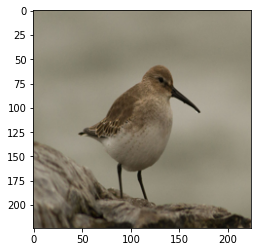

In [226]:
print(f'Pertinent negative prediction: {explanation.PN_pred}')
plt.imshow(explanation.PN[0]/255);

In [231]:
cnn.predict(explanation.PN / 255).argmax(), cnn.predict(explanation.PN /255).max()

(669, 0.051648863)

# Generate pertinent positive

In [38]:
mode = 'PP'

In [39]:
# initialize CEM explainer and explain instance
cem = CEM(cnn, mode, shape, kappa=kappa, beta=beta, feature_range=feature_range,
          gamma=gamma, ae_model=ae, max_iterations=max_iterations,
          c_init=c_init, c_steps=c_steps, learning_rate_init=lr, clip=clip, no_info_val=no_info_val)

explanation = cem.explain(X)

Pertinent positive prediction: 5


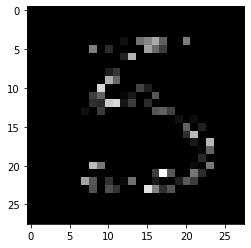

In [40]:
print(f'Pertinent positive prediction: {explanation.PP_pred}')
plt.imshow(explanation.PP.reshape(28, 28));